In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import optimize
import plotly.graph_objs as go
import corner
import emcee
from IPython.display import display, Math

In [2]:
def intensity(kinetic_energy, max_energy, Z):
    """spectrum function"""
    me = 0.511*1000 #keV
    return np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy)

def Fermi_function(Z, kinetic_energy):
    me = 0.511*1000 #keV
    a = 1/137
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    x = 2*np.pi*Z*a*E/pc
    return x/(1-np.exp(-x))

In [3]:
def B(x, k, i, t):
    """
    B-spline
    t : numpy array
      knots
    k, i : int
      spline number
    return: B_ki spline at point x
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2



def T(x, x_knots, b):
    """
    time strategy
    x_knots : numpy array
    b : numpy array
      weights
    return: time at point x
    """
    t = x_knots
    T = 1e-19
    for i in range(1, len(t)-5):
        T += b[i-1]*B(x, 3, i, t)
    
    return T

In [4]:
def experimental_lin(kinetic_energy, max_energy, noise, calibr, lin, Z=2, me=511):
    """
    function for fitting with linear additive
    """
    return calibr*(np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy) -lin*(max_energy - kinetic_energy)) + noise 

def intensity_lin(kinetic_energy, max_energy, ampl, Z=2, me=511):
    """
    function for intensity with linear additive
    """
    return np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy)-ampl*(max_energy - kinetic_energy)

In [5]:
def div_max(kinetic_energy, max_energy=18.57, ampl=10**4, Z=2, me=511):
    """
    derivative of max energy parameter 
    """
    return np.sqrt(kinetic_energy ** 2 + 2 * kinetic_energy * me) * 2 * (max_energy - kinetic_energy) * (
            kinetic_energy + me) * Fermi_function(Z, kinetic_energy) - ampl


def div_ampl(kinetic_energy, max_energy=18.57, ampl=10**4, Z=2, me=511):
    """
    derivative of additive amplitude parameter 
    """
    return -(max_energy - kinetic_energy)


def div_cal(kinetic_energy, max_energy=18.57, ampl=10**4, Z=2, me=511):
    """
    derivative of calibration parameter 
    """
    return np.sqrt(kinetic_energy ** 2 + 2 * kinetic_energy * me) * (max_energy - kinetic_energy) ** 2 * (
            kinetic_energy + me) * Fermi_function(Z, kinetic_energy) -ampl*(max_energy - kinetic_energy)


def div_mass(kinetic_energy, m, max_energy=18.57, ampl=10**4, Z=2, me=511):
    """
    derivative of mass parameter 
    """
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    div = np.zeros(len(kinetic_energy))
    for i in range(len(kinetic_energy)):
        if max_energy - kinetic_energy[i] > 0:
            div[i] = Fermi_function(Z, kinetic_energy[i]) * (kinetic_energy[i] + me) *pc[i]*(max_energy - kinetic_energy[i])*np.sqrt((max_energy - kinetic_energy[i])**2 - m**2) - lin*(max_energy - kinetic_energy[i])
        else:
            div[i] = 0
    return div


#derivative of noise is equal to one


def inversed_fisher_information(b, x_knots, derivatives, KEs, dist):
    """
    inverse fisher infromation matrix
    x_knots : numpy array
    derivatives : numpy array
      array of derivatives
    dist : numpy array
      intensity array
    normolize : double
      area normalization (as not to change the total time)
    return: max energy sigma
    """
    time = np.array([T(x, x_knots, b) for x in KEs])
    summ = np.sum(time)
    b0 = np.ones(len(x_knots) - 6)
    y0 = np.array([T(x, x_knots, b0) for x in KEs])
    normolize = np.sum(y0)
    time = time * normolize / summ
    length = len(derivatives)
    FIM = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            FIM[i][j] = np.sum(time*derivatives[i]*derivatives[j]/dist)
    return np.sqrt(np.linalg.inv(FIM)[0][0])

In [6]:
def parameters_error_and_corr(b, x_knots, KEs, dist, b0):
    time = np.array([T(x, x_knots, b) for x in KEs])
    time0 = np.array([T(x, x_knots, b0) for x in KEs])
    time = time*np.sum(time0)/ np.sum(time)
    y = np.random.poisson(dist*time)/time
    popt, pcov = optimize.curve_fit(f = experimental_lin, xdata= KEs, ydata=y,
                                    p0 = [18.57,  0, 1, 10**4], sigma=np.sqrt(dist*time)/time, absolute_sigma=True,
                                    bounds=((18, -150, 0., 0.5*10**4), (19, 150, 2, 1.5*10**4)), method= 'dogbox')
    sigmas = np.sqrt(np.diag(pcov))
    corr = np.zeros(3)
    j=0
    for i in range(1 + j, 4):
        corr[i+j-1] = pcov[j][i]/(sigmas[j]*sigmas[i])
    return sigmas, corr

In [28]:
max_energy = 18.57 
n = 1000 # number of points
KEs = np.linspace(0.0001, max_energy - 0.2, n) #kinetic energies 

derivatives = np.array([div_max(KEs), np.ones(len(KEs)), div_cal(KEs), div_ampl(KEs)]) 
dist = intensity_lin(KEs, max_energy, 10 ** 4) #intensity
a = 0 #start of grid
b = max_energy #end of grid
x_knots = np.concatenate([np.linspace(a-2, a-0.5, 3), np.linspace(a, b, 10), np.linspace(b + 1.5, b + 3.5, 3)])
b0 = np.ones(len(x_knots) - 6) #initial weights
bl = tuple(np.zeros(len(x_knots) - 6)) #lower bound
bw = tuple(np.ones(len(x_knots) - 6)*50) #upper bound
bnds = optimize.Bounds(bl, bw) #bounds

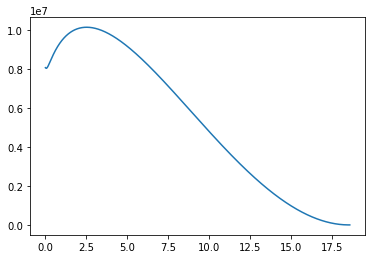

In [74]:
plt.plot(KEs, intensity_with_mass_lin(KEs, 3*0.001, max_energy, 10**4))

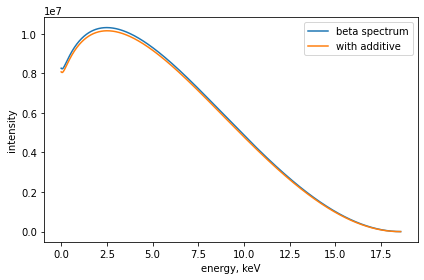

In [66]:
plt.plot(KEs, intensity_lin(KEs, max_energy, 0), label='beta spectrum')
plt.plot(KEs, intensity_lin(KEs, max_energy, 10**4), label='with additive')
plt.legend()
plt.xlabel('energy, keV')
plt.ylabel('intensity')
plt.tight_layout()
#plt.savefig('figs_pres/beta_spectrum_tritium.png', dpi=300, transparent=True)

In [29]:
%%time
optimize.minimize(inversed_fisher_information, x0=b0, args=(x_knots, derivatives, KEs, dist), method='L-BFGS-B', bounds=bnds, options={'maxfev':5000 ,'maxiter':5000})

<timed eval>:1: OptimizeWarning: Unknown solver options: maxfev


Wall time: 49.6 s


      fun: 0.00018535401059094854
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.88767796e-08,  1.24366581e-05,  1.42927635e-05,  6.98190963e-06,
        1.19939865e-06, -1.39702431e-06, -8.23378362e-07,  2.96238728e-06,
        7.17353694e-06,  9.05357604e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 66
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([3.39071528, 0.        , 0.        , 0.        , 0.37270615,
       0.89830754, 0.94977332, 0.36802   , 0.        , 0.40644482])

In [26]:
bo = [3.44899946, 0.        , 0.        , 0.        , 0.        ,
       1.31942577, 1.37361597, 0.        , 0.        , 0.36451806] #the best estimator
#bo = [3.45167171, 0.        , 0.        , 0.        , 0.36480123,
 #      1.02824388, 0.95836002, 0.07092656, 0.        , 0.3834182 ]
#bo = [3.51082672, 1.54640647, 0.        , 0.        , 0.        ,
 #      0.09761826, 0.43725114, 0.68056174, 0.89934814, 0.73793738,
  #     0.50826708, 0.31029301, 0.        , 0.0055206 , 0.54435925]

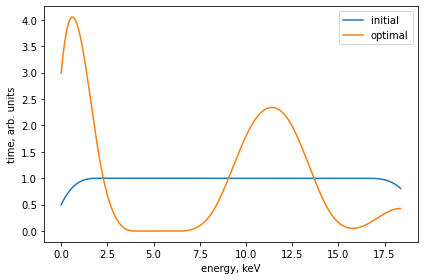

In [27]:
time0 = np.array([T(x, x_knots, b0) for x in KEs])
time1 = np.array([T(x, x_knots, bo) for x in KEs])
norm = np.sum(time0)/np.sum(time1)
time3 = time1*norm
plt.plot(KEs, time0,  label='initial')
plt.plot(KEs, time3,  label='optimal')
#plt.plot(np.ones(10)*11.6, np.linspace(0,4, 10))
plt.legend()
plt.xlabel('energy, keV')
plt.ylabel('time, arb. units')
plt.tight_layout()
#plt.savefig('figs_pres/strategy_tritium.png', dpi=300, transparent=True)

In [43]:
KEs[np.argmax(time3)], np.max(dist)

(0.6069135135135135, 10151093.407149881)

In [ ]:
inversed_fisher_information(
    b0, x_knots, derivatives, KEs, dist)/inversed_fisher_information(bo, x_knots, derivatives, KEs, dist)

In [22]:
inversed_fisher_information(
    b0, x_knots, derivatives, KEs, dist)/inversed_fisher_information(bo, x_knots, derivatives, KEs, dist)

1.5442920693112607

In [20]:
np.random.seed(4)
y0 = np.array([T(x, x_knots, b0) for x in KEs])
b=bo
time = np.array([T(x, x_knots, b) for x in KEs])
time = time*np.sum(y0)/np.sum(time)

y = np.random.poisson(dist*time)/time 
y00 = np.random.poisson(dist*y0)/y0 

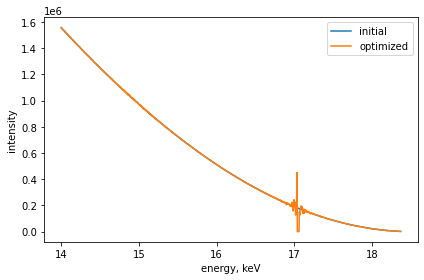

In [21]:
plt.plot(KEs, y00, label='initial')
plt.plot(KEs, y, label='optimized')
plt.legend()
plt.xlabel('energy, keV')
plt.ylabel('intensity')
plt.tight_layout()
#plt.savefig('figs_pres/spectrum_tritium_optimized.png', dpi=300, transparent=True)

In [22]:
print(parameters_error_and_corr(b0, x_knots, KEs, dist, b0))
print(parameters_error_and_corr(bo, x_knots, KEs, dist, b0))

(array([4.34852912e-02, 4.31118875e+02, 2.71618743e-03, 7.62085306e+03]), array([0.99943459, 0.99881693, 0.99999002]))
(array([3.37621342e-02, 4.26137845e+02, 2.13039681e-03, 5.91606148e+03]), array([0.99957844, 0.99825308, 0.99998323]))


In [204]:
def log_likelihood(theta, energy, y, time):
    max_energy, noise, calibr, lin = theta
    model = experimental_lin(energy, max_energy, noise, calibr, lin)
    data = model*time
    data[data<=0] = 10e-19
    sigma = np.sqrt(data)/time
    sigma[sigma<=0] = 10e-19
    return -0.5 * np.sum((y - model) ** 2 / sigma**2 + np.log(sigma**2))


def log_prior(theta):
    max_energy, noise, calibr, lin = theta
    if 18 < max_energy < 19 and -150.0 < noise < 150.0 and 0. < calibr < 2.0:
        return 0.0
    return -np.inf


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [192]:
%%time
np.random.seed(93284)
pos = np.array([18.57, 0, 1, 10**4]) + 1e-4 * np.random.randn(24, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(KEs, y, time))
                                #moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2),])
sampler.run_mcmc(pos, 50000, progress=True)

C:\ProgramData\Anaconda3\lib\site-packages\emcee\ensemble.py:255: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:39<00:00, 312.88it/s]

Wall time: 2min 39s


State([[ 1.85698663e+01  5.29445011e+01  1.00012536e+00  1.00517223e+04]
 [ 1.85699162e+01  7.03990744e+01  1.00014202e+00  1.00660672e+04]
 [ 1.85699618e+01  2.82135888e+01  1.00006476e+00  1.00358133e+04]
 [ 1.85700900e+01  6.76352865e+01  1.00017309e+00  1.00894376e+04]
 [ 1.85700396e+01  3.39565347e+01  1.00008529e+00  1.00503397e+04]
 [ 1.85699416e+01  3.51533876e+01  1.00018178e+00  1.00810783e+04]
 [ 1.85702087e+01  9.26664740e+01  1.00015926e+00  1.01020653e+04]
 [ 1.85699566e+01  7.03149863e+01  1.00023123e+00  1.01231923e+04]
 [ 1.85699953e+01  5.47779164e+01  1.00019979e+00  1.01023365e+04]
 [ 1.85703206e+01  1.81011097e+01  1.00018981e+00  1.01181954e+04]
 [ 1.85699577e+01  3.36528965e+01  9.99910213e-01  9.94317381e+03]
 [ 1.85700427e+01  2.38251373e+01  1.00015843e+00  1.00693787e+04]
 [ 1.85701545e+01  2.09475780e+01  1.00004395e+00  1.00285091e+04]
 [ 1.85700427e+01  9.23683121e+01  1.00025542e+00  1.01335752e+04]
 [ 1.85700376e+01  9.21001357e+01  1.00027030e+00  1.014

Text(0.5, 0, 'step number')

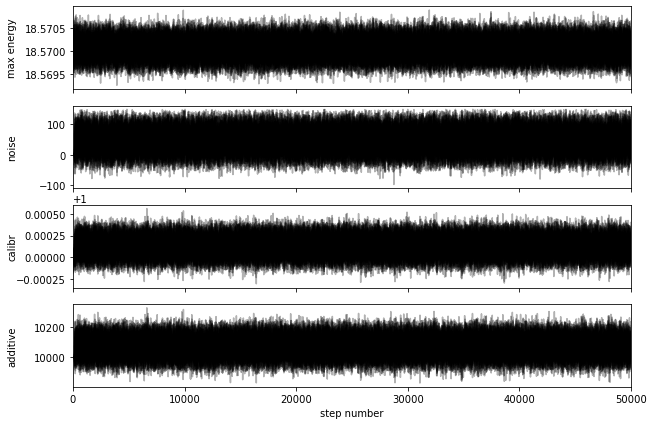

In [193]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["max energy", "noise", "calibr", "additive"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [194]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

[50.93543392 51.70246158 50.78764331 51.03108497]
(79512, 4)


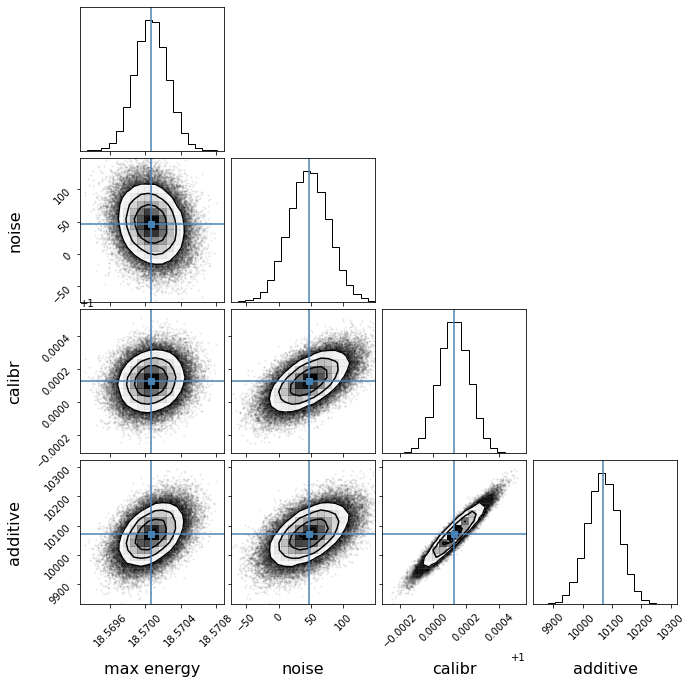

In [195]:
centers = np.zeros(ndim)
for i in range(ndim):
    centers[i] = np.percentile(flat_samples[:, i], [16, 50, 84])[1]

emcee_corner = corner.corner(flat_samples,labels=labels, truths=centers,
                            label_kwargs={"fontsize": 16}, labelpad=0.1)

#plt.savefig('figs_pres/tritium_parameters_space_optimized_weights.png', dpi=400, transparent=True)

In [196]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [191]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Свертки

In [46]:
from scipy.integrate import quad
def integrateQ(func, a, b):
    res = quad(func, a,b)
    return res[0]

def integrateR(func, a, b, numPoints = 1000):
    points, step = np.linspace(a, b, numPoints, endpoint=True, retstep=True)
    return np.sum(func(points))*step

from scipy.integrate import simps
def integrateS(func, a, b, numPoints = 1000):
    x = np.linspace(a,b, numPoints, endpoint=True)
    return simps(x = x, y = func(x))

integrate = integrateQ

In [52]:
convolute = lambda f, g, a, b: np.vectorize(lambda x: integrate(lambda y: f(x-y)*g(y), a, b))
sigma = 0.1
g = lambda x : 1/np.sqrt(2*np.pi)/sigma*np.exp(-x*x/2/sigma/sigma)
time = lambda x : T(x, x_knots, bo)
time = np.vectorize(time)

In [25]:
%%time
conv = convolute(time, g, 0.001, max_energy)(KEs)

Wall time: 4min 59s


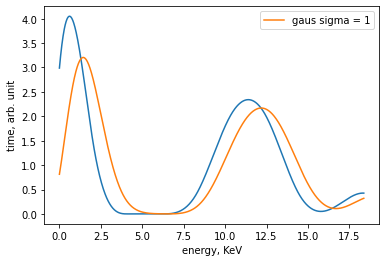

In [28]:
y0 = np.array([T(x, x_knots, b0) for x in KEs])
conv_normed = conv*np.sum(y0)/np.sum(conv)
plt.plot(KEs, time3)
plt.plot(KEs, conv_normed, label='gaus sigma = 1')
plt.xlabel("energy, KeV")
plt.ylabel("time, arb. unit")
plt.legend()
#plt.savefig("figs/convolute_strategy_gaus_1_quad.png", dpi=150)

In [33]:
def inversed_fisher_information_time(time, derivatives, KEs, dist):
    """
    inverse fisher infromation matrix
    x_knots : numpy array
    derivatives : numpy array
      array of derivatives
    dist : numpy array
      intensity array
    normolize : double
      area normalization (as not to change the total time)
    return: max energy sigma
    """
    
    length = len(derivatives)
    FIM = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            FIM[i][j] = np.sum(time*derivatives[i]*derivatives[j]/dist)
    return np.sqrt(np.linalg.inv(FIM)[0][0])

In [34]:
inversed_fisher_information_time(
    y0, derivatives, KEs, dist)/inversed_fisher_information_time(conv_normed, derivatives, KEs, dist)

1.2580740506151133

In [35]:
spectrum = lambda x: intensity_lin(x, max_energy, 10 ** 4)
spectrum = np.vectorize(spectrum)

In [50]:
%%time
dist_conv = convolute(spectrum, g, 0.001, max_energy - 0.4)(KEs)

<ipython-input-16-446a4b487bbc>:11: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy)-ampl*(max_energy - kinetic_energy)
<ipython-input-14-bcbe2ae3f298>:10: RuntimeWarning: invalid value encountered in sqrt
  pc = np.sqrt(E**2 - me**2)
<ipython-input-46-34624b5ee5c3>:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = quad(func, a,b)
<ipython-input-46-34624b5ee5c3>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and 

Wall time: 53 s


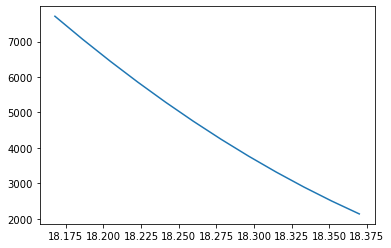

In [51]:
#plt.plot(KEs, dist)
plt.plot(KEs, dist_conv)